In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
dataset = pd.read_excel('America 2017.xlsx')

In [3]:
dataset.head()

,First Year Bookings AMT (USD),Closed Won Date
0,33250.00,2017-04-27
1,1484.00,2018-09-07
2,0.93,2017-09-19
3,18800.00,2018-12-21
4,105.60,2017-05-02


In [4]:
dataset.shape

(35723, 2)

In [5]:
# dataset = dataset.loc[dataset['First Year Bookings AMT (USD)'] > 0]

In [6]:
dataset['Closed Won Date'] = pd.to_datetime(dataset['Closed Won Date'])

In [7]:
dataset = dataset.groupby('Closed Won Date')['First Year Bookings AMT (USD)'].sum()

In [8]:
dataset = dataset.to_frame()

In [9]:
dataset.head()

,First Year Bookings AMT (USD)
Closed Won Date,
2017-01-03,8773.51
2017-01-04,14242.96
2017-01-05,199650.23
2017-01-06,13211.08
2017-01-09,64080.56


In [10]:
dataset = dataset.sort_values(by='Closed Won Date')

In [11]:
dataset.shape

(711, 1)

In [12]:
# test_threshold = 0.1
# threshold = dataset.shape[0] - int(dataset.shape[0]*test_threshold)
threshold = dataset.shape[0] - 210
training_set = dataset.iloc[:threshold,0:1].values
training_set.shape

(501, 1)

## Feature Scaling

In [13]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

## Create a dataset with n timesteps and 1 output

In [14]:
timesteps = 80

In [15]:
X_train = []
y_train = []

for i in range(timesteps, training_set.shape[0]):
    X_train.append(training_set_scaled[i-timesteps:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [16]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Building the RNN

In [17]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [18]:
regressor = Sequential()

In [19]:
# First LSTM Layer
regressor.add(LSTM(units = 100,
                   return_sequences = True,
                   input_shape = (X_train.shape[1], 1)))

# Dropout
regressor.add(Dropout(rate=0.2))

In [20]:
# Second LSTM Layer
regressor.add(LSTM(units = 100,
                   return_sequences = True))

# Dropout
regressor.add(Dropout(rate=0.2))

In [21]:
# Third LSTM Layer
regressor.add(LSTM(units = 100,
                   return_sequences = True))

# Dropout
regressor.add(Dropout(rate=0.2))

In [22]:
# Fourth LSTM Layer
regressor.add(LSTM(units = 100))

# Dropout
regressor.add(Dropout(rate=0.2))

In [23]:
# Output Layer
regressor.add(Dense(units = 1))

In [24]:
regressor.compile(optimizer = 'adam', loss = 'MSE')

## Training

In [25]:
regressor.fit(x = X_train,
              y = y_train,
              epochs = 30,
              batch_size = 32)

Epoch 1/30
421/421 [==============================] - 13s 30ms/step - loss: 0.0042
Epoch 2/30
421/421 [==============================] - 6s 14ms/step - loss: 0.0042
Epoch 3/30
421/421 [==============================] - 10s 24ms/step - loss: 0.0043
Epoch 4/30
421/421 [==============================] - 6s 14ms/step - loss: 0.0043
Epoch 5/30
421/421 [==============================] - 6s 15ms/step - loss: 0.0041
Epoch 6/30
421/421 [==============================] - 9s 21ms/step - loss: 0.0041
Epoch 7/30
421/421 [==============================] - 6s 13ms/step - loss: 0.0042
Epoch 8/30
421/421 [==============================] - 6s 14ms/step - loss: 0.0041
Epoch 9/30
421/421 [==============================] - 7s 16ms/step - loss: 0.0042
Epoch 10/30
421/421 [==============================] - 7s 17ms/step - loss: 0.0041
Epoch 11/30
421/421 [==============================] - 6s 14ms/step - loss: 0.0041
Epoch 12/30
421/421 [==============================] - 6s 14ms/step - loss: 0.0040
Epoch 13/30

## Prediction

In [26]:
test_set = dataset.iloc[threshold-timesteps:,0:1].values

In [27]:
X_test = []

for i in range(timesteps, test_set.shape[0]):
    X_test.append(test_set[i-timesteps:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [28]:
X_test.shape

(210, 80, 1)

In [29]:
y_predicted = regressor.predict(X_test)

In [30]:
y_predicted = sc.inverse_transform(y_predicted)

## Visualization

In [31]:
y_real = dataset.iloc[threshold:,0:1].values

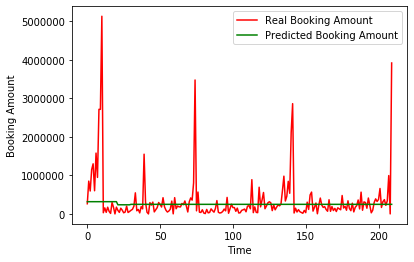

In [32]:
plt.plot(y_real, color='red', label='Real Booking Amount')
plt.plot(y_predicted, color='green', label='Predicted Booking Amount')
plt.xlabel('Time')
plt.ylabel('Booking Amount')
plt.legend()
plt.show()

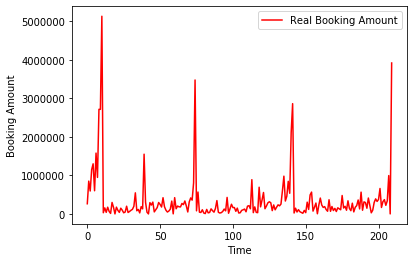

In [33]:
plt.plot(y_real, color='red', label='Real Booking Amount')
plt.xlabel('Time')
plt.ylabel('Booking Amount')
plt.legend()
plt.show()

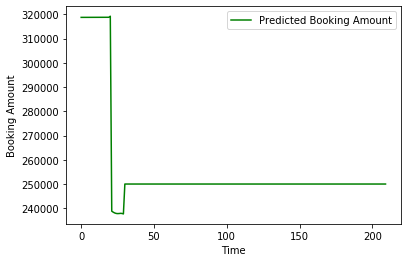

In [34]:
plt.plot(y_predicted, color='green', label='Predicted Booking Amount')
plt.xlabel('Time')
plt.ylabel('Booking Amount')
plt.legend()
plt.show()

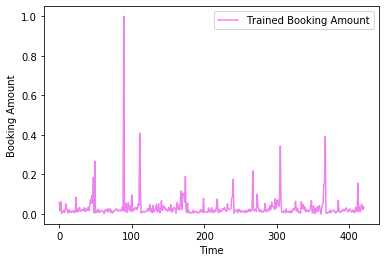

In [35]:
plt.plot(y_train, color='violet', label='Trained Booking Amount')
plt.xlabel('Time')
plt.ylabel('Booking Amount')
plt.legend()
plt.show()

## Model Evaluation

In [36]:
import math
from sklearn.metrics import mean_squared_error

In [37]:
rmse = math.sqrt(mean_squared_error(y_real, y_predicted))

In [38]:
rmse

624368.009696022

In [39]:
relative_rmse = rmse/(dataset['First Year Bookings AMT (USD)'].max() - dataset['First Year Bookings AMT (USD)'].min())
relative_rmse

0.05115964660914047